<a href="https://colab.research.google.com/github/tozanni/Deep_Learning_Notebooks/blob/main/ANN_paso_a_paso_con_Numpy_parte_2_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feed-Forward ANN realmente paso a paso con NumPy

Recordemos la arquitectura de la red del ejemplo que venimos estudiando:

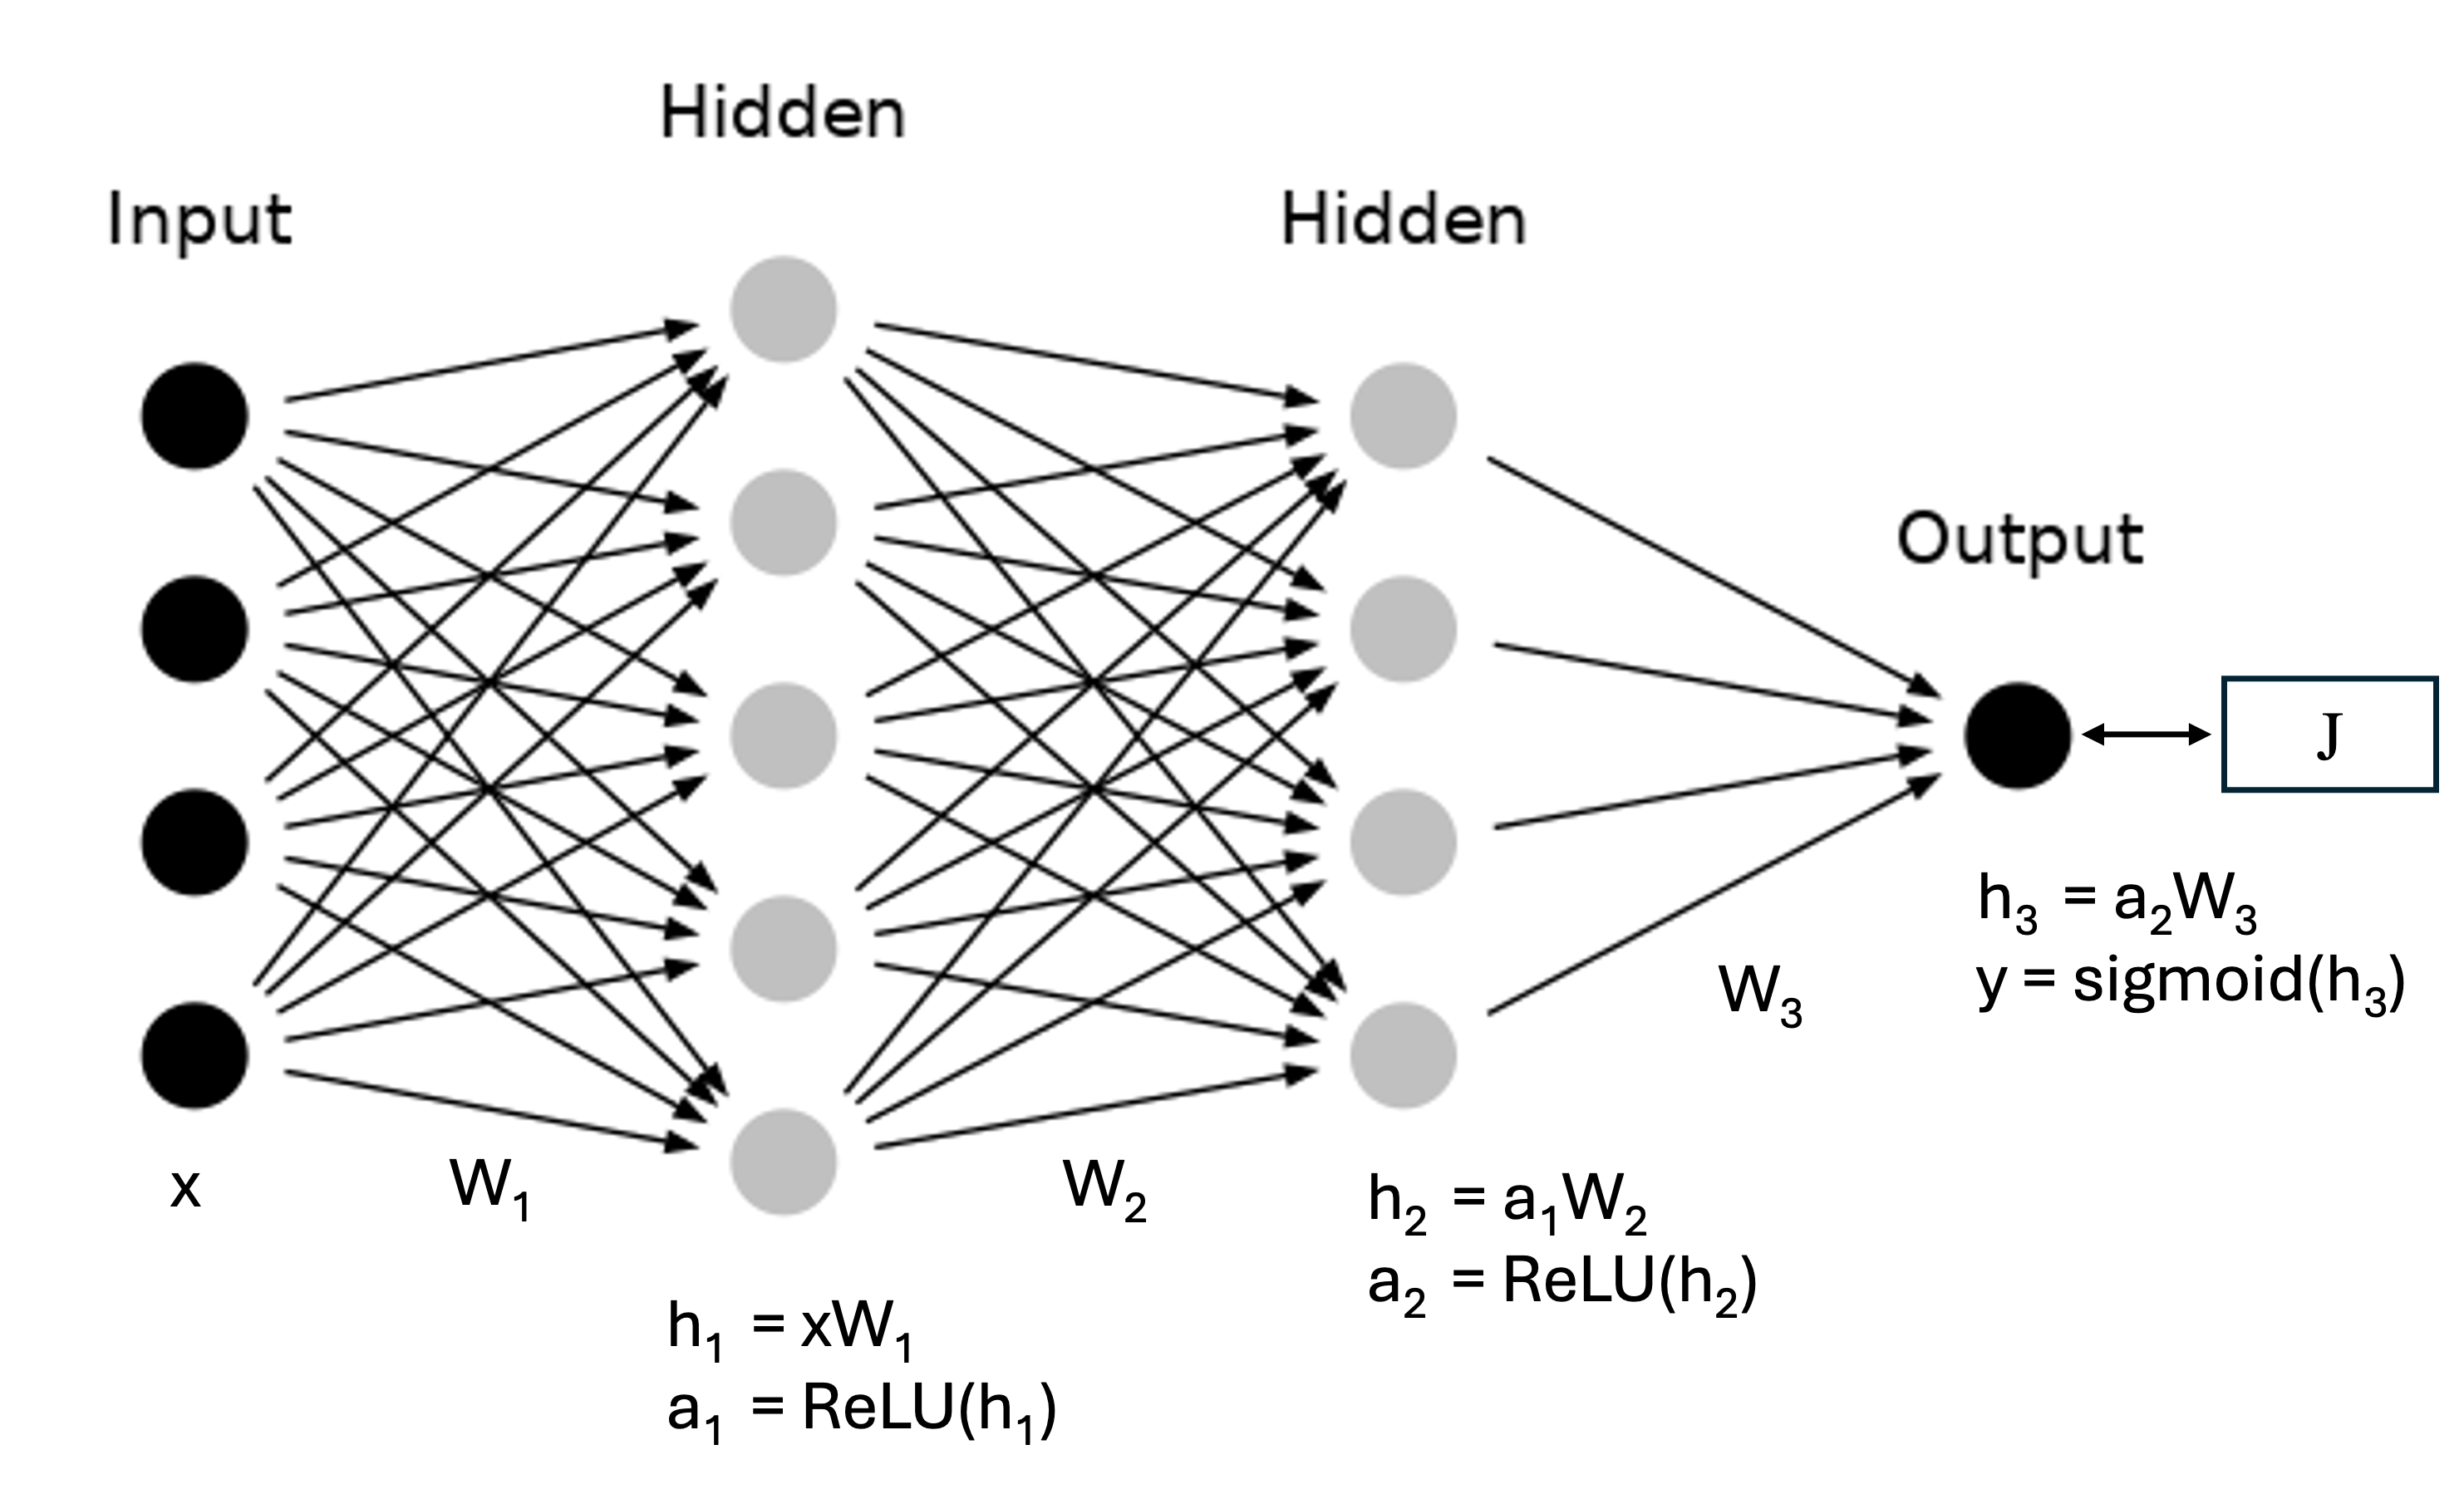

Parte 1:

https://github.com/tozanni/Deep_Learning_Notebooks/blob/main/Feed_Forward_ANN_Paso_a_Paso_con_Numpy_Parte_1.ipynb

## Parte 2. Backward pass

En la primera parte de este tutorial, definimos una red de perceptrones multicapa y ejecutamos el forward pass paso a paso.

### 1. Preparación de datos y forward pass resumido

En resumen el forward pass se puede definir en la siguientes líneas:

In [1]:
# Bibliotecas
import numpy as np
from sklearn import datasets
np.random.seed(42)
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

# Dataset (IRIS)
iris = datasets.load_iris()
X = np.array(iris.data[:100])
Y = np.array(iris.target[:100])

# Estandarizar
X = (X - np.mean(X)) / np.std(X)

# Obtener una instancias del dataset para clasificar
# con algunos ajustes se pueden procesar más instancias simultáneamente!
x = X[:1]
x

array([[1.0913, 0.2378, -0.8825, -1.5226]])

Recordemos que estamos analizando una red con 4 nodos de input y dos capas ocultas, una de 5 nodos (W_1) y una de 4 nodos (W_2). La clasificación final es una activación de tipo sigmoidal.

Realizaremos la iteración del forward pass con dos instancias del dataset simultáneamente para demostrar los beneficios de la representación matricial.

Definimos e inicializamos de forma aleatoria las matrices de pesos de esta red y ejecutamos el forward pass de forma compacta.

Recordando que las activaciones entre H1 y H2 son ReLU, se implementan con la función np.maximum(x,0) y la activación final es sigmoidal. En este caso sí definiré una función ya que la versión paso a paso del forward pass se explicó en el notebook previo.


In [2]:
# Inicializacion
W1 = np.random.rand(4, 5) #4 variables de input x 5 nodos de H1
W2 = np.random.rand(5, 4) #5 nodos de H1 x 4 nodos de H2
W3 = np.random.rand(4, 1) #4 nodos de H2 x 1 nodo de salida

# Forward pass
h1 = x@W1 #Valores de los nodo hidden de la capa 1
a1 = np.maximum(h1,0) #Activación relu en la capa 1

h2 = a1@W2 #Valores de los nodos hidden de la capa 2
a2 = np.maximum(h2,0) #Activación relu de la capa 2

h3 = a2@W3 #Valor del nodo hidden de la capa 3
yhat = 1/(1 + np.exp(-h3)) #Activacion sigmoidal de la capa 3 (prediccion)
yhat

#Notacion compacta (solo inferencia)
#y_hat = sigmoid(np.maximum(np.maximum(x@W_1,0)@W_2,0)@W_3)

array([[0.5181]])

#### Última capa

El primer paso del backward pass en "backpropagation" es cuantificar el error entre la predicción de la red y las etiquetas. Aunque este es un problema de clasificación y sería más correcto utilizar la función de pérdida BCE o Log Loss, utilizaremos el error medio cuadrático (MSE) ya que es más sencilla para efectos didácticos. Primero obtenemos los datos etiquetados como comparación.

In [3]:
# Obtenemos las primera observacion
ytrue = Y[:1]

#Convertimos de renglon a columnas con reshape
#ytrue = np.reshape(ytrue,(-1,1))
ytrue

array([0])

Calculamos el error medio cuadrático, usaremos J ya que representa la función de costo

$$
J = \frac{1}{2}(\widehat{y} - y)^{2}
$$

In [4]:
J = (1/2)*(yhat - ytrue)**2
J

array([[0.1342]])

El siguiente paso es obtener el gradiente de la pérdida con respecto a los parámetros (W) de la capa anterior. Pero no podemos calcular este valor directamente, en vez de ello utilizaremos la regla de la cadena, multiplicando las derivadas de las variables "intermedias".

$$
 \frac{\partial J}{\partial W_3} = \frac{\partial J}{\partial \widehat{y}} \frac{\partial \widehat{y}}{\partial h_3} \frac{\partial h_3}{\partial W_3}
$$

Para ello comenzaremos calculando la derivada parcial del costo con respecto de la predicción $\widehat{y}$ utilizando las fórmulas de sus derivadas:

$$
\frac{\partial J}{\partial \widehat{y}} = \widehat{y} - y
$$


In [5]:
dJ_yhat = yhat - ytrue
dJ_yhat

array([[0.5181]])

Listo, el segundo componente de la fórmula es la parcial de $\widehat{y}$ que es el valor de activacion de la ultima capa con respecto del $h_3$ que es el producto punto de pesos por inputs de la capa previa. Sabemos que $\widehat{y}$ es una función de activación sigmoidal, por lo tanto su derivada es:
$$
\frac{\partial \widehat{y}}{\partial h_3} = \widehat{y}( 1 - \widehat{y})
$$

In [6]:
dyhat_h3 = yhat*(1 - yhat)
dyhat_h3

array([[0.2497]])

El ultimo componente de la capa 3 es derivada parcial de $h_3$ con respecto a los parámetros $W_3$ en este caso la función que calcula $h_3$ es una transformación lineal $h_3 = a_2 W_3 $ , por lo tanto $\frac{\partial h_3}{\partial W_3} = a_2$

OJO: Trasponemos la derivada de la matriz de pesos.

In [7]:
dh3_W3 = a2.T
dh3_W3

array([[0.0908],
       [0.0207],
       [0.0434],
       [0.0544]])

Finalente, calculamos el valor $
 \frac{\partial J}{\partial W_3} = \frac{\partial J}{\partial \widehat{y}} \frac{\partial \widehat{y}}{\partial h_3} \frac{\partial h_3}{\partial W_3}$:

In [8]:
dJ_W3 = dJ_yhat*dyhat_h3*dh3_W3
dJ_W3

array([[0.0117],
       [0.0027],
       [0.0056],
       [0.0070]])

En este caso tenemos 4 derivadas para cada uno de los pesos de $W_3$

#### Capa 2

La capa 2 consiste en una matriz de 5x4 pesos, con 4 nodos de salida con activación ReLU. La derivada de la función ReLU está indefinida en cero sin embargo, para efectos prácticos se considera igual a 1 para el caso de x >= 0, es decir, $\frac{\partial f}{\partial x} = x( x > 0)$

Como puedes ver es una función computacionalmente muy sencilla de calcular y resulta una aproximación conveniente a otras funciones más "smooth".  Para mayor detalle sobre la derivada de la función ReLU y otras funciones de activación te recomiendo esta [referencia](https://mmuratarat.github.io/2019-02-10/some-basic-activation-functions).

Las ecuaciones de los gradientes de la capa 2 son las siguientes, notar que los primeros dos términos $\frac{\partial J}{\partial \widehat{y}} \frac{\partial \widehat{y}}{\partial h_3}$ ya los tenemos calculados del paso anterior:

$$
 \frac{\partial J}{\partial W_2} = \frac{\partial J}{\partial \widehat{y}} \frac{\partial \widehat{y}}{\partial h_3} \frac{\partial h_3}{\partial a_2} \frac{\partial a_2}{\partial h_2} \frac{\partial h_2}{\partial W_2}
$$

**Derivadas de la capa 2**

A continuación terminaremos de calcular el resto de los términos de la capa 2 haciendo uso de su función original y de la fórmula de su derivada en cada caso.

$ h_3 = a_2 W_3$ por lo tanto $\frac{\partial h_3}{\partial a_2} = W_3$

$ a_2 = ReLU(h_2) = max(0,h_2) $ por lo tanto $\frac{\partial a_2}{\partial h_2} = h_2( h_2 > 0)$

$ h_2 = a_1W_2$ por lo tanto $\frac{\partial h_2}{\partial W_2} = a_1$


In [9]:
# Calculamos los nuevos terminos

dh3_a2 = W3.T #Ojo: Trasponer

da2_h2 = h2*(h2 > 0)

dh2_W2 = a1.T #Ojo: Trasponer

In [10]:
dJ_yhat * dyhat_h3 * dh3_a2

array([[0.0158, 0.0640, 0.0044, 0.1176]])

In [11]:
da2_h2

array([[0.0908, 0.0207, 0.0434, 0.0544]])

In [12]:
dJ_yhat * dyhat_h3 * dh3_a2 * da2_h2

array([[0.0014, 0.0013, 0.0002, 0.0064]])

In [13]:
dh2_W2

array([[0.1484],
       [0.0000],
       [0.0000],
       [0.0000],
       [0.0000]])

A manera de comprobacion es importante revisar que el gradiente que estamos calculando coincida en dimensiones con la matriz que queremos actualizar, es decir $W_2$

In [14]:
dJ_W2 = dJ_yhat * dyhat_h3 * dh3_a2 * da2_h2 * dh2_W2
dJ_W2

array([[0.0002, 0.0002, 0.0000, 0.0009],
       [0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.0000, 0.0000]])

#### Capa 1

La capa 1, consiste en 4 neuronas de input y 5 neuronas hidden, con lo cual forma la matriz W_1 de 20 pesos. Las neuronas hidden de la capa 1 utilizan la función de activación ReLU cuya derivada recién explicamos en el paso previo.

En esta capa finalmente lograremos conectar la pérdida J, con el cambio en pesos de la capa 1. Nuevamente utilizando la regla de la cadena, la fórmula quedaría de la siguiente manera, donde los primeros 4 términos ya estan calculados:

$$
 \frac{\partial J}{\partial W_1} = \frac{\partial J}{\partial \widehat{y}} \frac{\partial \widehat{y}}{\partial h_3} \frac{\partial h_3}{\partial a_2} \frac{\partial a_2}{\partial h_2} \frac{\partial h_2}{\partial a_1} \frac{\partial a_1}{\partial h_1}\frac{\partial h_1}{\partial W_1}
$$


**Derivadas de la capa 1**

A continuación terminaremos de calcular el resto de los términos de la capa 1:

$ h_2 = a_1 W_2$ por lo tanto $\frac{\partial h_2}{\partial a_1} = W_2$

$ a_1 = ReLU(h_1) = max(0,h_1) $ por lo tanto $\frac{\partial a_1}{\partial h_1} = h_1( h_1 > 0)$

$ h_1 = xW_1$ por lo tanto $\frac{\partial h_1}{\partial W_1} = x$ es decir el input recibido por la red neuronal.


In [15]:
dh2_a1 = W2
da1_h1 = (h1*(h1 > 0)).T #Ojo: Trasponer
dh1_W1 = x

In [33]:
dJ_W1 = dJ_yhat * dyhat_h3 * dh3_a2 * da2_h2 * dh2_a1 * da1_h1 * dh1_W1
dJ_W1

array([[0.0001, 0.0000, -0.0000, -0.0005],
       [-0.0000, -0.0000, 0.0000, 0.0000],
       [-0.0000, -0.0000, 0.0000, 0.0000],
       [-0.0000, -0.0000, 0.0000, 0.0000],
       [-0.0000, -0.0000, 0.0000, 0.0000]])

El resultado del gradiente dJ_W1 tiene el numero correcto de elementos (20), pero podemos ver que las dimensiones no coinciden con nuestra matriz de pesos original. Para resolver este tema debemos trasponer la matriz del gradiente.

In [34]:
dJ_W1.shape, W1.shape

((5, 4), (4, 5))

In [35]:
dJ_W1 = dJ_W1.T

### Actualización de pesos

Ya hemos calculado todos los gradientes necesarios para actualizar los pesos. El siguiente paso es actualizarlos utilizando la regla de actualización que depende de un hiperparámetro, la learning rate.

Las fórmulas para actualizar los pesos de cada capa son las siguientes:

$$
W_1' = W_1 - \alpha \frac{\partial J}{\partial W_1}
$$

$$
W_2' = W_2 - \alpha \frac{\partial J}{\partial W_2}
$$

$$
W_3' = W_3 - \alpha \frac{\partial J}{\partial W_3}
$$

In [27]:
alpha = 1

# NUevos pesos W1
W1 - alpha*dJ_W1

array([[0.3744, 0.9507, 0.7320, 0.5987, 0.1560],
       [0.1560, 0.0581, 0.8662, 0.6011, 0.7081],
       [0.0206, 0.9699, 0.8324, 0.2123, 0.1818],
       [0.1839, 0.3042, 0.5248, 0.4319, 0.2912]])

In [28]:
# Nuevos pesos W2
W2 - alpha*dJ_W2

array([[0.6116, 0.1393, 0.2921, 0.3654],
       [0.4561, 0.7852, 0.1997, 0.5142],
       [0.5924, 0.0465, 0.6075, 0.1705],
       [0.0651, 0.9489, 0.9656, 0.8084],
       [0.3046, 0.0977, 0.6842, 0.4402]])

In [29]:
# Nuevos pesos W3
W3 - alpha*dJ_W3

array([[0.1103],
       [0.4925],
       [0.0288],
       [0.9023]])